In [1]:
import numpy as np
import pandas as pd
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import core
import extra

In [2]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [4]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [5]:
dirpath = 'IIIT-CFW'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


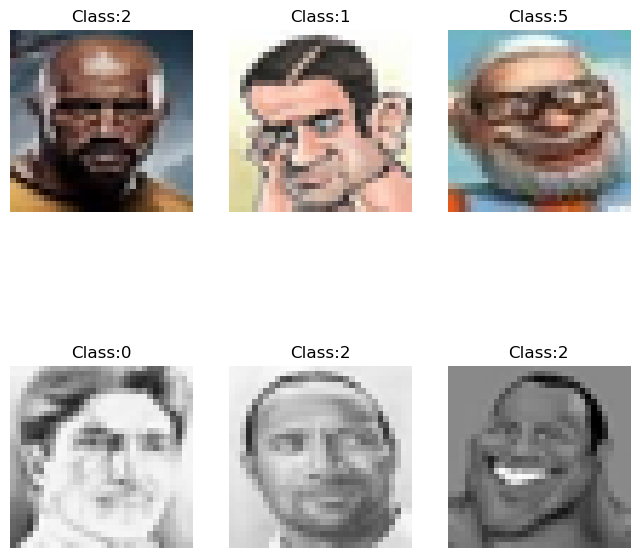

In [6]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

# Q-1.1 PCA 

### 1.1.1 Preprocess of IIIT-CFW dataset

convertion of 4D data to 2D data

In [7]:
X_n = np.reshape(X,[672,3072])
print(X_n.shape)

(672, 3072)


Note: The PCA model class is in the core.py file

In [8]:
#PCA model
n_com = 300
mypca = core.MY_PCA(n_components=n_com)
mypca.fit(X_n)
X_pca, eigenvalues = mypca.transform(X_n)

In [9]:
total_variance = np.sum(eigenvalues)
e_var = eigenvalues[:n_com] / total_variance
cum_e_var = np.cumsum(e_var)

### 1.1.2 Plot the cumulative explained variance vs No. of principal components 

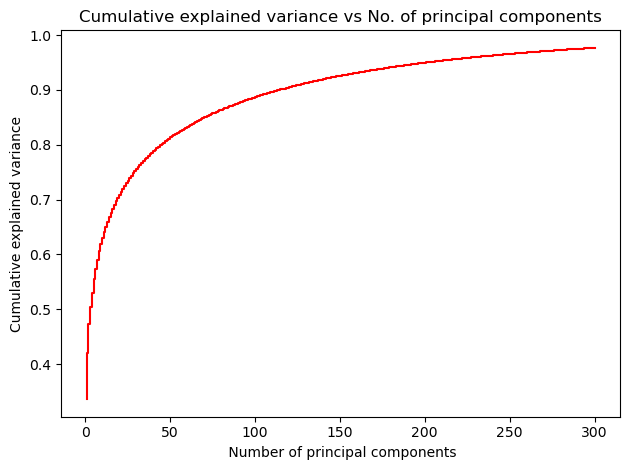

In [11]:
a = 1+n_com
plt.step(range(1, a), cum_e_var, color='red')

plt.ylabel('Cumulative explained variance')
plt.xlabel(' Number of principal components')
plt.title('Cumulative explained variance vs No. of principal components')
plt.tight_layout()


### 1.1.3 Dimensionality reduction on features of pictionary dataset (assignment-1).

### KNN without PCA

In [12]:
def KNN_Run(h_param, test_split_ratio=0.2):
    hy_param = extra.hyper_param(h_param)
    f_1_score = []
    accuracy = []
    precision = []
    recall = []
 
    # output = []

    dataset = np.load("data.npy",allow_pickle=True)

    
    for i in hy_param:

        my_knn = core.KNN_Opt(i)
        encoder = i[1]
        if encoder == 'RESNET':
            X_train = dataset[:,1]  # Load the Data
            X_train = np.concatenate([item.flatten() for item in X_train]).reshape(1500, 1024)     #for RESNETs 1st column
            
        elif encoder == 'VIT':
            X_train = dataset[:,2]  # Load the Data
            X_train = np.concatenate([item.flatten() for item in X_train]).reshape(1500, 512)      #for VITs 2nd column
            
            '''flatten-convert nD array to 1D array, concatenate-work like flatten for list, convert list to 1D array '''
        
        y_train = dataset[:,3]
        X_train, X_test, y_train, y_test = extra.train_test_split(X_train, y_train, test_size=test_split_ratio, random_state=42)

        my_knn.fit(X_train, y_train)
        predictions = my_knn.predict(X_test)

        f_1_score_t, accuracy_t, precision_t, recall_t = extra.output_of_knn(predictions, y_test)
        f_1_score.append(f_1_score_t)
        accuracy.append(accuracy_t)
        precision.append(precision_t)
        recall.append(recall_t)
    return f_1_score, accuracy, precision, recall, len(hy_param)

In [13]:
h1_param = {
        'k_list' : [3],
        'encoder_list' : ['VIT'],
        'distance_matrix_list' : ['Euclidean']
        }
hy_param = extra.hyper_param(h1_param)
f_1_score, accuracy, precision, recall, len_hy = KNN_Run(h1_param)

### KNN with PCA

In [14]:
def KNN_Run(h_param, test_split_ratio=0.2):
    hy_param = extra.hyper_param(h_param)
    f_1_score = []
    accuracy = []
    precision = []
    recall = []
 
    # output = []

    dataset = np.load("data.npy",allow_pickle=True)
    n_PCA_com = [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150]
    
    for j in n_PCA_com:
        i = hy_param[0]
        my_knn = core.KNN_Opt(i)
    
        X_train = dataset[:,2]  # Load the Data
        X_train = np.concatenate([item.flatten() for item in X_train]).reshape(1500, 512)      #for VITs 2nd column
        
        '''flatten-convert nD array to 1D array, concatenate-work like flatten for list, convert list to 1D array '''
        
        n_com = j
        mypca_pic = core.MY_PCA(n_components=n_com)
        mypca_pic.fit(X_train)
        X_pca_pic, eigenvalues_pic = mypca_pic.transform(X_train)
    
        X_pca_pic = np.array(X_pca_pic)

        y_train = dataset[:,3]
        X_train, X_test, y_train, y_test = extra.train_test_split(X_pca_pic, y_train, test_size=test_split_ratio, random_state=42)

        my_knn.fit(X_train, y_train)
        predictions = my_knn.predict(X_test)

        f_1_score_t, accuracy_t, precision_t, recall_t = extra.output_of_knn(predictions, y_test)
        f_1_score.append(f_1_score_t)
        accuracy.append(accuracy_t)
        precision.append(precision_t)
        recall.append(recall_t)
    return f_1_score, accuracy, precision, recall, n_PCA_com

h1_param = {
    'k_list' : [3],
    'encoder_list' : ['VIT'],
    'distance_matrix_list' : ['Euclidean']
    }
hy_param_pca = extra.hyper_param(h1_param)
f_1_score_pca, accuracy_pca, precision_pca, recall_pca, n_PCA_com = KNN_Run(h1_param)


### Printing the table for PCA and non PCA results

In [15]:
result_list = np.array([f_1_score, accuracy, precision, recall]).T
results = pd.DataFrame(result_list, columns= ['f-1 score','Accuracy', 'Precision','Recall'])
# print(result_list.shape)
print(results)
print('\n')

result_list_pca = np.array([n_PCA_com, f_1_score_pca, accuracy_pca, precision_pca, recall_pca]).T
results_pca = pd.DataFrame(result_list_pca, columns= ['n_PCA_com','f-1 score_pca','Accuracy_pca', 'Precision_pca','Recall_pca'])
print(results_pca)

   f-1 score  Accuracy  Precision    Recall
0   0.173877  0.283333   0.178372  0.200436


    n_PCA_com  f-1 score_pca  Accuracy_pca  Precision_pca  Recall_pca
0         1.0       0.008469      0.010000       0.015244    0.008892
1         5.0       0.051843      0.100000       0.054595    0.055604
2        10.0       0.067791      0.123333       0.068621    0.073988
3        15.0       0.095830      0.166667       0.101012    0.105446
4        20.0       0.100692      0.196667       0.101687    0.113010
5        25.0       0.109236      0.200000       0.116989    0.118522
6        30.0       0.122866      0.213333       0.133583    0.131712
7        35.0       0.133159      0.223333       0.146963    0.137847
8        40.0       0.129672      0.233333       0.134242    0.138929
9        45.0       0.130723      0.233333       0.137472    0.140113
10       50.0       0.127839      0.236667       0.134322    0.138081
11       55.0       0.134752      0.240000       0.141316    0.150125


Observations:   
For the hyperparameters : [3,'VIT','Euclidean'] i get best accuracy of 28.33% in my KNN model.
Then with PCA implimentation in the KNN model the accuracy is increase as the number of principle component increase. for number of principal component greter than 100 the accuracy is nearly reach the accuracy of the original data.

### 1.1.4 Accuracy for dimensionality reduction varying the principal components from 1 to n

In [16]:
X_n = np.reshape(X,[672,3072])
print(X_n.shape)
y_test_cfw = y
print(y_test_cfw.shape)

(672, 3072)
(672,)


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

accuracy_list = []
n = 100 
for i in range(n):

    #PCA 
    n_com = i+1
    mypca_pic = core.MY_PCA(n_components=n_com)
    mypca_pic.fit(X_n)
    X_pca_pic, eigenvalues_pic = mypca_pic.transform(X_n)
    X_pca_pic = np.real(X_pca_pic)
    #KNN classifier
    x_train, x_test, y_train, y_test = train_test_split(X_pca_pic, y_test_cfw, test_size=0.2, random_state=22)

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

In [18]:
print(accuracy_list)

[0.21481481481481482, 0.2740740740740741, 0.34814814814814815, 0.31851851851851853, 0.3111111111111111, 0.3851851851851852, 0.3851851851851852, 0.3925925925925926, 0.37777777777777777, 0.4, 0.45925925925925926, 0.45185185185185184, 0.4444444444444444, 0.43703703703703706, 0.42962962962962964, 0.4444444444444444, 0.4666666666666667, 0.4666666666666667, 0.4740740740740741, 0.48148148148148145, 0.4740740740740741, 0.4740740740740741, 0.4444444444444444, 0.45185185185185184, 0.4740740740740741, 0.48148148148148145, 0.4888888888888889, 0.4666666666666667, 0.4444444444444444, 0.45925925925925926, 0.4740740740740741, 0.4666666666666667, 0.4962962962962963, 0.48148148148148145, 0.4740740740740741, 0.4740740740740741, 0.48148148148148145, 0.4962962962962963, 0.5037037037037037, 0.5037037037037037, 0.5111111111111111, 0.4962962962962963, 0.48148148148148145, 0.4740740740740741, 0.4666666666666667, 0.4740740740740741, 0.4666666666666667, 0.4666666666666667, 0.4740740740740741, 0.48148148148148145

In [23]:
m = np.argmax(accuracy_list)
print("No. of Principal component for max accuracy:", m)

No. of Principal component for max accuracy: 40


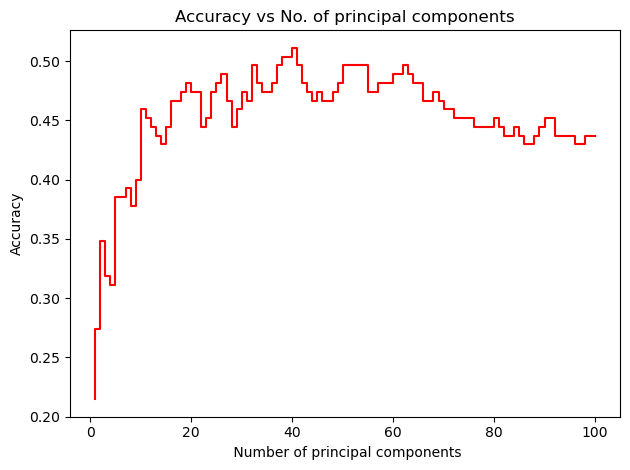

In [19]:
a = n+1
plt.step(range(1, a), accuracy_list, color='red')

plt.ylabel('Accuracy')
plt.xlabel(' Number of principal components')
plt.title('Accuracy vs No. of principal components')
plt.tight_layout()

Observations:    
In above plot of accuracy vs no of principal component the maximum accuracy is achived at no. of PC = 40.
So, this results shows the application of PCA in the image data compression and classification. 

# 1.2 PCA for both drawer and guesser

In [5]:
g_data = pd.read_csv('smai_assignment_pictionary_1_2/guesser_attributes.csv')
print(g_data.shape)
print(g_data.columns)
n_com = 2
mypca_pic = core.MY_PCA(n_components=n_com)
mypca_pic.fit(g_data)
X_pca_pic_g, eigenvalues_pic = mypca_pic.transform(g_data)
print(X_pca_pic_g.shape)

(100, 7)
Index(['g_guesser', 'g_noofmessage_median', 'g_firstmessagetime_median',
       'g_lastmessagetime_median', 'g_rangemessagetime_median',
       'g_pcgamesconfusion', 'g_entropy'],
      dtype='object')
(100, 2)


In [7]:
g_data_n = (g_data-np.mean(g_data,axis=0))/np.std(g_data)

In [6]:
#  calculation of inforamation hold by particular PCA using eigen values
s = eigenvalues_pic/np.sum(eigenvalues_pic)
print(s[0],s[2])

0.5026677045838464 0.1492379240000204


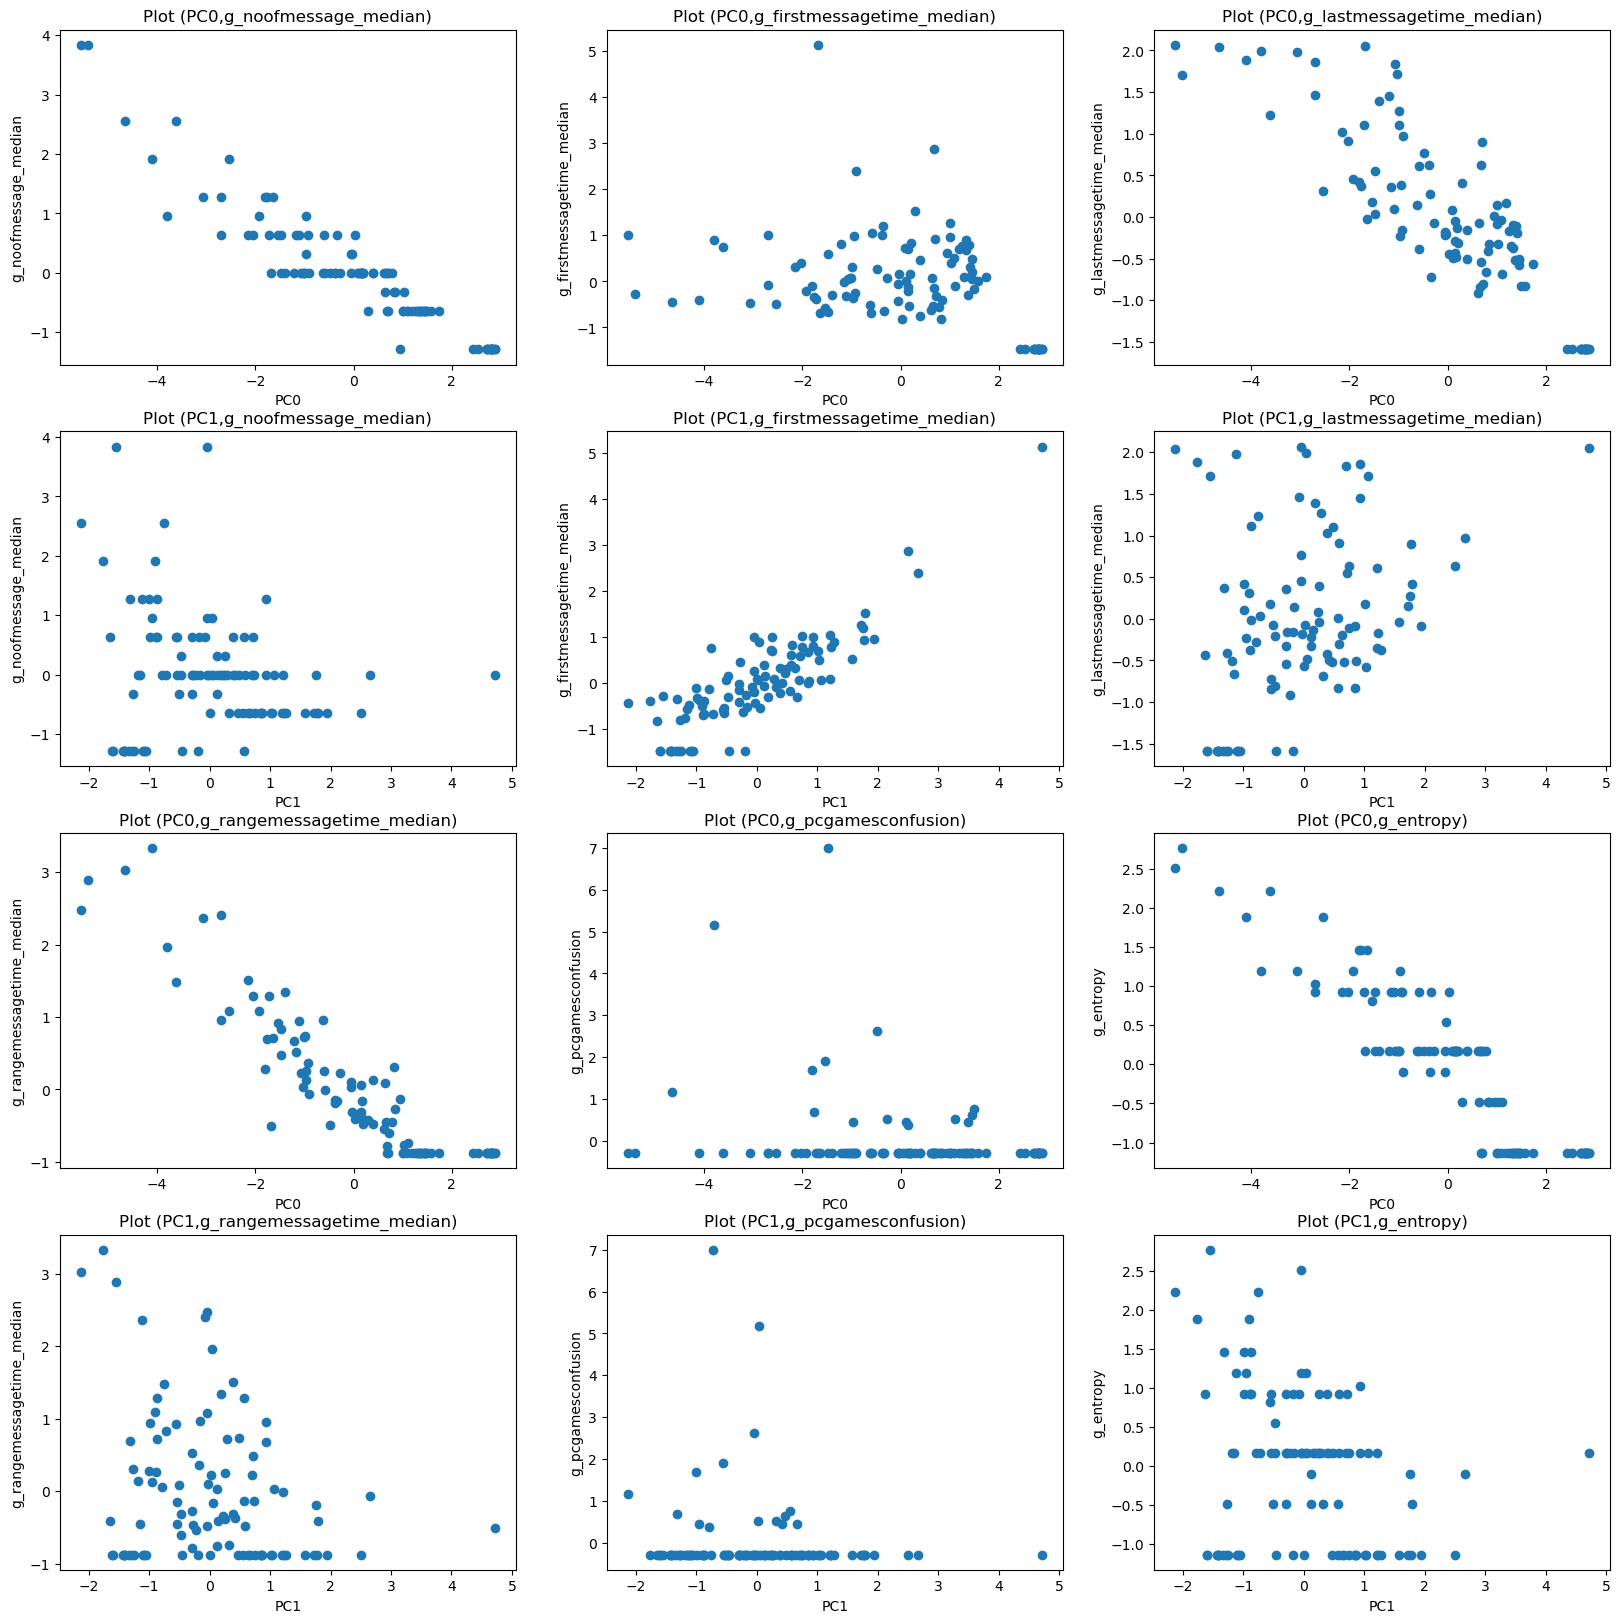

In [10]:
#Plot of the Drawer
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
for i in range(2):
    for j in range(3):       
        axes[i, j].scatter(X_pca_pic_g[f'PC{i}'], g_data_n[g_data.columns[j+1]] )
        axes[i, j].set_title(f'Plot (PC{i},{g_data.columns[j+1]})')
        axes[i, j].set(xlabel = f'PC{i}', ylabel = g_data.columns[j+1])
for i in range(2):
    for j in range(3):       
        axes[i+2, j].scatter(X_pca_pic_g[f'PC{i}'], g_data_n[g_data.columns[j+1+3]] )
        axes[i+2, j].set_title(f'Plot (PC{i},{g_data.columns[j+1+3]})')
        axes[i+2, j].set(xlabel = f'PC{i}', ylabel = g_data.columns[j+1+3])

This data shows that for PC0 the data is more spread towards x-axis(PC0 axis) compare to PC1. which shows that PC0 give more information about data compare to PC1.

### Drawer

In [14]:
# PCA 
d_data = pd.read_csv('smai_assignment_pictionary_1_2/drawer_attributes.csv')
# print(d_data.columns)
print(d_data.shape)
n_com = 2
mypca_pic = core.MY_PCA(n_components=n_com)
mypca_pic.fit(d_data)
X_pca_pic_d, eigenvalues_pic = mypca_pic.transform(d_data)
print(X_pca_pic_d.shape)

(100, 9)
(100, 2)


In [15]:
#  calculation of inforamation hold by particular PCA using eigen values
s_d = eigenvalues_pic/np.sum(eigenvalues_pic)
print(s_d[0],s_d[2])

0.41507789181504234 0.13524902898210878


In [16]:
#Preprocessing of the data before ploting
d_data_n = (d_data-np.mean(d_data,axis=0))/np.std(d_data)

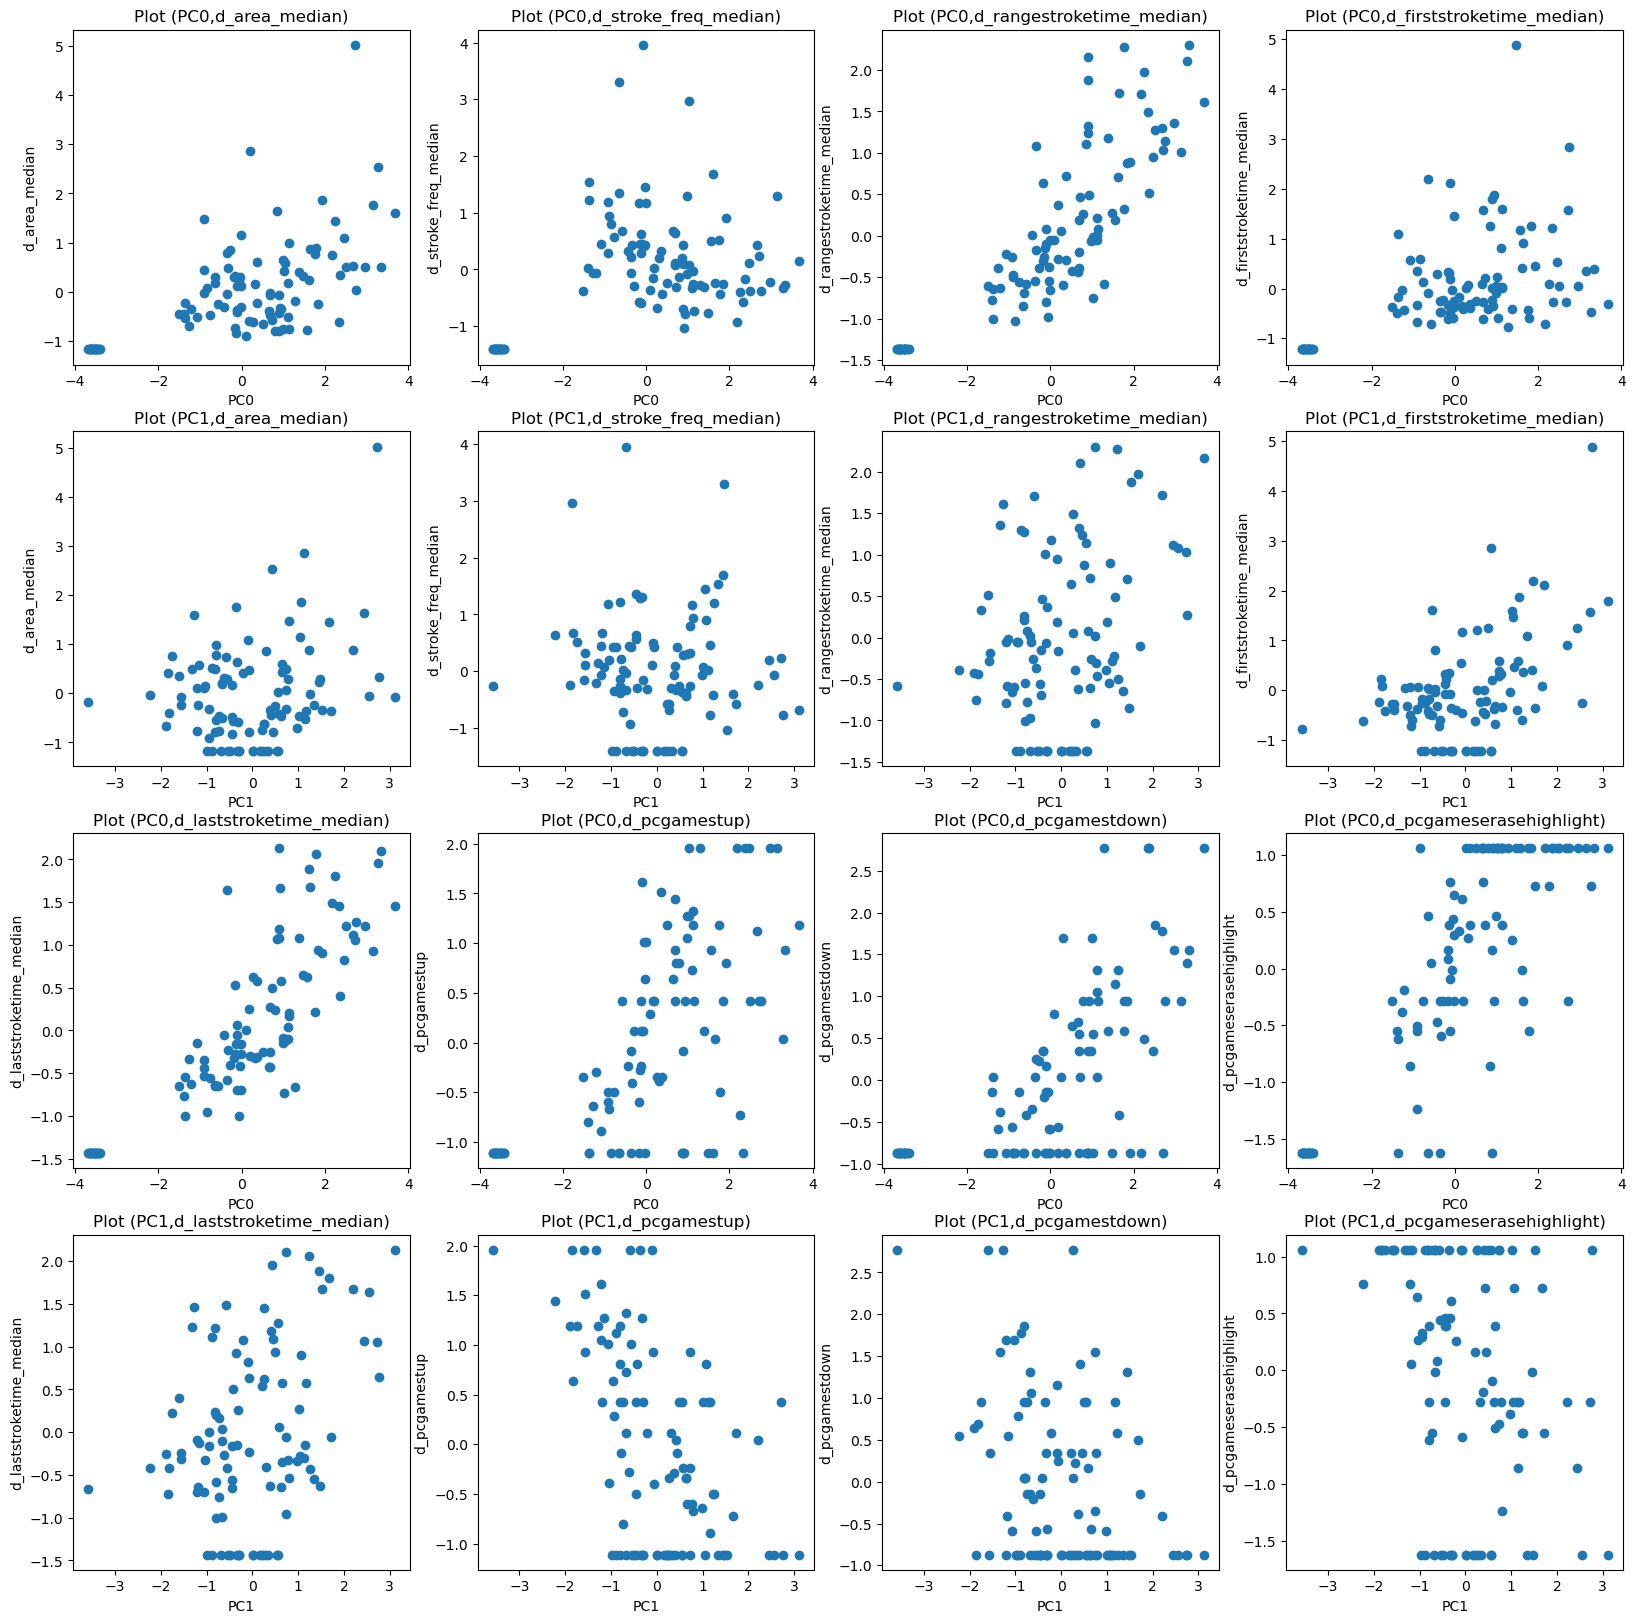

In [17]:
#Plot of the Drawer
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for i in range(2):
    for j in range(4):       
        axes[i, j].scatter(X_pca_pic_d[f'PC{i}'], d_data_n[d_data.columns[j+1]] )
        axes[i, j].set_title(f'Plot (PC{i},{d_data.columns[j+1]})')
        axes[i, j].set(xlabel = f'PC{i}', ylabel = d_data.columns[j+1])
for i in range(2):
    for j in range(4):       
        axes[i+2, j].scatter(X_pca_pic_d[f'PC{i}'], d_data_n[d_data.columns[j+1+4]] )
        axes[i+2, j].set_title(f'Plot (PC{i},{d_data.columns[j+1+4]})')
        axes[i+2, j].set(xlabel = f'PC{i}', ylabel = d_data.columns[j+1+4])


This data shows that for PC0 the data is more spread towards x-axis(PC0 axis) compare to PC1. which shows that PC0 give more information about data compare to PC1. in most cases the direct relation of PC0 and PC1 with old feature is not observed (except PC0 vs Rangetime_strocketime_median). which can shows that in the given drawer_data the information is spread across all the features.